# 生成式模型介绍两种

* 变分自动编码器（VAE）

   * 根植于贝叶斯推理

* 生成式对抗网络（GAN）及其变种

   * 基于博弈论，目的是找到纳什均衡的判别网络和生成网络
   

# 8.1、用变分自编码器生成图像

* 变分自编码器是自编码器的改进版本

* 自编码器是一种无监督学习

* 网络结构

<img src="Screenshot from 2021-03-17 16-57-50.png">

In [33]:
# 导入包

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

torch.cuda.set_device(0)
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_dir = 'ave_samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


# 超参数
image_size = 784 # 28*28
h_dim = 400
z_dim = 20
num_epochs = 30
batch_size = 128
learning_rate = 0.001

In [13]:
# 下载数据集

dataset = torchvision.datasets.MNIST(root='./data',
                                    train=True,
                                    transform=transforms.ToTensor(),
                                    download=True)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

In [14]:
# 构建AVE模型，主要由Encode和Decode两部分组成

class VAE(nn.Module):
    def __init__(self,image_size=784,h_dim=400,z_dim=20):
        super(VAE,self).__init__()
        self.fc1 = nn.Linear(image_size,h_dim)
        self.fc2 = nn.Linear(h_dim,z_dim)
        self.fc3 = nn.Linear(h_dim,z_dim)
        self.fc4 = nn.Linear(z_dim,h_dim)
        self.fc5 = nn.Linear(h_dim,image_size)
    
    def encode(self,x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self,mu,log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu+eps*std
    
    def decode(self,z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self,x):
        mu,log_var = self.encode(x)
        z = self.reparameterize(mu,log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [15]:
# 选择优化器

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
# 训练模型，同时保存原图像与随机生成图像


for epoch in range(num_epochs):
    model.train()
    for i, (x, _) in enumerate(data_loader):
        # 前向传播
        model.zero_grad()
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)

        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # 反向传播
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f"Epoch[{epoch+1}/{num_epochs}], step[{i+1}/{len(data_loader)}], reconst loss:{reconst_loss.item():.4f}, kl_div:{kl_div.item():.4f}")
    
    with torch.no_grad():
        # 保存采样图像,即潜在向量Z通过解码器生成的新图像
        z = torch.randn(batch_size,z_dim).to(device)
        out = model.decode(z).view(-1,1,28,28)
        save_image(out, os.path.join(sample_dir, f'sqmpled-{epoch+1}.png'))
    
        # 保存重构图像,即原图像通过解码器生成的图像
        out,_,_ = model(x)
        x_concat = torch.cat([x.view(-1,1,28,28),out.view(-1,1,28,28)],dim=3)
        save_image(x_concat, os.path.join(sample_dir, f'reconst-{epoch+1}.png'))

/home/xieyipeng/anaconda3/envs/torch/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xieyipeng/anaconda3/envs/torch/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch[1/30], step[100/469], reconst loss:12105.0352, kl_div:3030.2427
Epoch[1/30], step[200/469], reconst loss:11439.7773, kl_div:3085.9541
Epoch[1/30], step[300/469], reconst loss:11163.7852, kl_div:3070.6594
Epoch[1/30], step[400/469], reconst loss:11552.5791, kl_div:3147.6392
Epoch[2/30], step[100/469], reconst loss:11400.9873, kl_div:3145.8074
Epoch[2/30], step[200/469], reconst loss:11755.9023, kl_div:3217.4639
Epoch[2/30], step[300/469], reconst loss:11053.1992, kl_div:3142.7839
Epoch[2/30], step[400/469], r

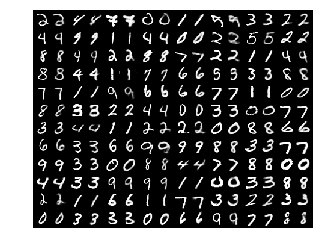

In [23]:
# 展示原图像及重构图像

import matplotlib.image as mping
import matplotlib.pyplot as plt

reconsPath = './ave_samples/reconst-30.png'
Image = mping.imread(reconsPath)
plt.imshow(Image)
plt.axis('off')
plt.show()

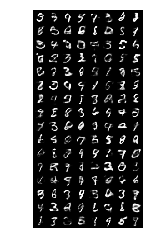

In [26]:
genPath = './ave_samples/sqmpled-30.png'
Image = mping.imread(genPath)
plt.imshow(Image)
plt.axis('off')
plt.show()

# GAN简介

* 基于博弈论，称为生成对抗网络

* GAN的优化不像通常的求损失函数的最小值，而是保持生成与判别两股力量的平衡

* 网络结构：

<img src="Screenshot from 2021-03-18 09-48-35.png">

## GAN的损失函数

* 目标很明确：既要不断提升判断器辨别真假的能力,又要不断提升生成器生成的图像质量

* 为达到判别器目的，他的损失函数既要考虑识别真图的能力，也要考虑识别假图的能力，即两者之和。

### 1、判别器损失函数：

```python

# D: 表示判别器
# G: 表示生成器
# images: 真图像
# 判别器对真图像的损失函数

outputs = D(images)
d_loss_real = criterion(outputs, real_labels)
real_score = outputs

# 判别器对假图像的损失
z = torch.randn(batch_size, latent_size).to(device)
fake_images = G(z)
outputs = D(fake_images)
d_loss_fake = criterion(outputs, fake_labels)
fake_score = outputs

d_loss = d_loss_real + d_loss_fake

```

### 2、生成器损失函数：

```python

z = torch.randn(batch_size, latent_size).to(device)
fake_images = G(z)
outputs = D(fake_images)

g_loss = criterion(outputs, real_labels)

```


In [45]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 超参数
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'gan_samples'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

trans = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]
)

mnist = torchvision.datasets.MNIST(root='./data3',train=True,transform=trans,download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist,batch_size=batch_size,shuffle=True)

In [50]:
# 构建网络

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

D = D.to(device)
G = G.to(device)

# 定义损失函数以及优化器
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# clamp函数将x限制在区间[0,1]内
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

total_step = len(data_loader)
total_step

600

In [54]:
# training

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 训练判别器
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_fake + d_loss_real

        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # 训练生成器
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        g_loss = criterion(outputs, real_labels)

        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1)%200 == 0:
            print(f"epoch [{epoch}/{num_epochs}], step [{i+1}/{total_step}],d_loss:{d_loss.item():.4f}, g_loss:{g_loss.item():.4f}, D(x):{real_score.mean().item():.2f}, D(G(z)):{fake_score.mean().item():.2f}")

    if (epoch+1) == 1:
        # 保存真图片
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # 保存假图片
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))


# 保存模型
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

:0.9483, g_loss:1.4166, D(x):0.73, D(G(z)):0.33
epoch [122/200], step [600/600],d_loss:0.7991, g_loss:1.6535, D(x):0.69, D(G(z)):0.24
epoch [123/200], step [200/600],d_loss:0.9979, g_loss:1.3502, D(x):0.72, D(G(z)):0.35
epoch [123/200], step [400/600],d_loss:0.8716, g_loss:1.7497, D(x):0.72, D(G(z)):0.31
epoch [123/200], step [600/600],d_loss:0.8761, g_loss:1.8345, D(x):0.71, D(G(z)):0.29
epoch [124/200], step [200/600],d_loss:0.8087, g_loss:1.6200, D(x):0.74, D(G(z)):0.30
epoch [124/200], step [400/600],d_loss:0.8582, g_loss:1.8066, D(x):0.71, D(G(z)):0.25
epoch [124/200], step [600/600],d_loss:0.8875, g_loss:1.6453, D(x):0.69, D(G(z)):0.27
epoch [125/200], step [200/600],d_loss:0.7667, g_loss:1.8722, D(x):0.75, D(G(z)):0.28
epoch [125/200], step [400/600],d_loss:0.8144, g_loss:1.7593, D(x):0.73, D(G(z)):0.28
epoch [125/200], step [600/600],d_loss:1.2845, g_loss:1.0191, D(x):0.71, D(G(z)):0.47
epoch [126/200], step [200/600],d_loss:0.8859, g_loss:1.8110, D(x):0.71, D(G(z)):0.30
epoch 

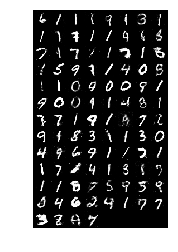

In [57]:
import matplotlib.image as mping
import matplotlib.pyplot as plt

reconsPath = './gan_samples/fake_images-200.png'
Image = mping.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

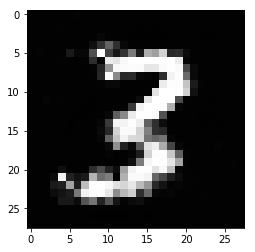

In [132]:
# test
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

z = torch.randn(1, latent_size).to(device)
fake_images = G(z).reshape(28, 28).cpu().detach().numpy() * 255
fake_images = Image.fromarray(np.uint8(fake_images))
plt.imshow(fake_images, cmap='gray')